In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
sns.set()

In [9]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    added = []
    offered = []
    time = 0
    rss = 0
    ds_type = None
    threads = 0
    file_count = 0
    buf_size = 0
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "BBB/build/bin" in line:
                ds_type = "BSBWT"
            elif line.startswith("threads = "):
                threads = int(line.split()[-1])
            elif line.startswith("max buffer size"):
                buf_size = float(line.split()[-2])
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "BSBWT":
                            data[f"{ds_type}-{threads}-{buf_size}"].append((time, rss))
                        else:
                            data[f"{ds_type}-{threads}"].append((time, rss))
            elif threads == 1 and line.startswith("Saw "):
                elems = int(line.split()[1]) // 2
                offered.append(elems)
            elif threads == 1 and line.startswith("Added"):
                elems = int(line.split()[1]) // 2
                added.append(elems)
            elif threads == 1 and "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
    return {
        "offered": offered,
        "size": sizes,
        "added": added, 
        "data": data
    }

In [36]:
def plot_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Insertion time (s)")
    plt.legend()
    plt.title("Insertion time")
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (M)")
    plt.legend()
    plt.title("Total Memory")
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [30]:
def plot_time_and_space_per_kmer(res, div, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] * 1000**3 / s for vv, s in zip(v, div)], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("insertion time ns / k-mer")
    plt.legend()
    plt.title("insertion time")
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS bits / k-mer")
    plt.legend()
    plt.title("memory efficiency")
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [11]:
coli_ins = read_res("../bbb_res/ins_coli.txt")

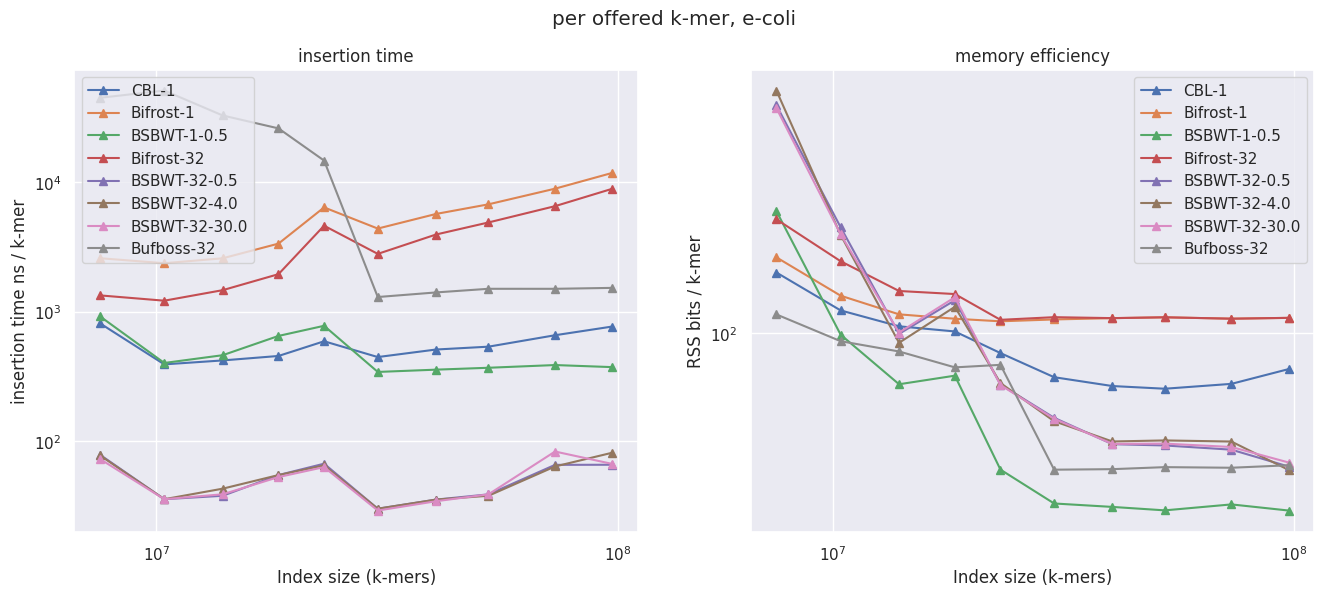

In [31]:
plot_time_and_space_per_kmer(coli_ins, coli_ins["offered"], "per offered k-mer, e-coli")

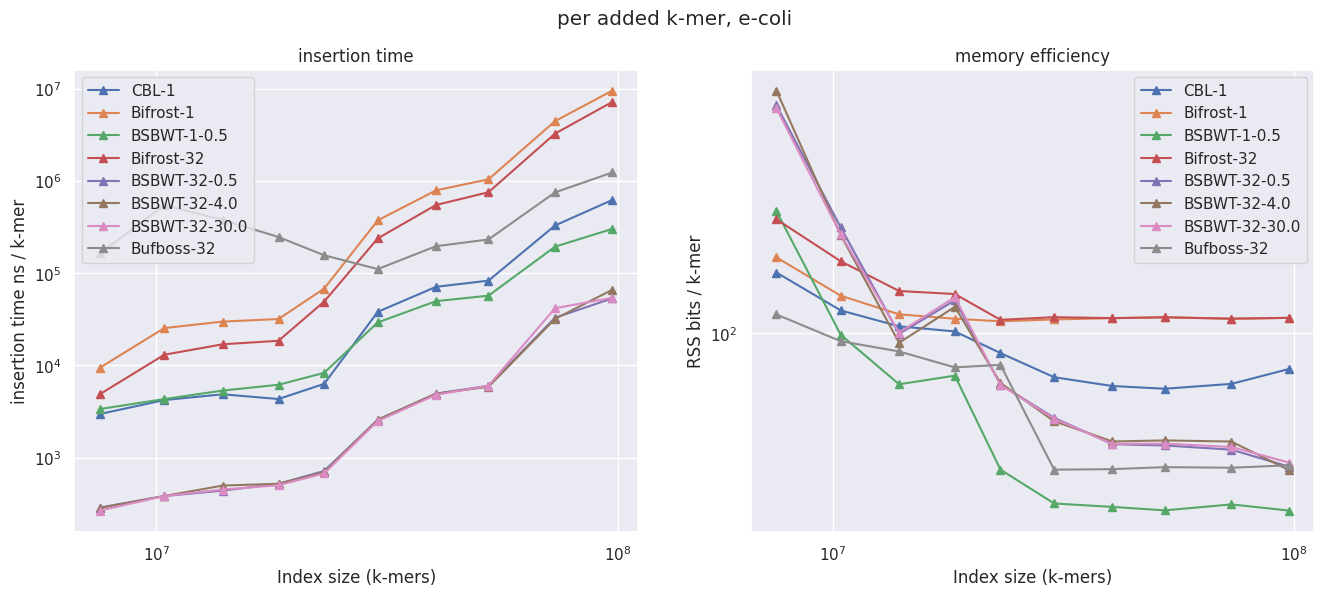

In [38]:
plot_time_and_space_per_kmer(coli_ins, coli_ins["added"], "per added k-mer, e-coli")

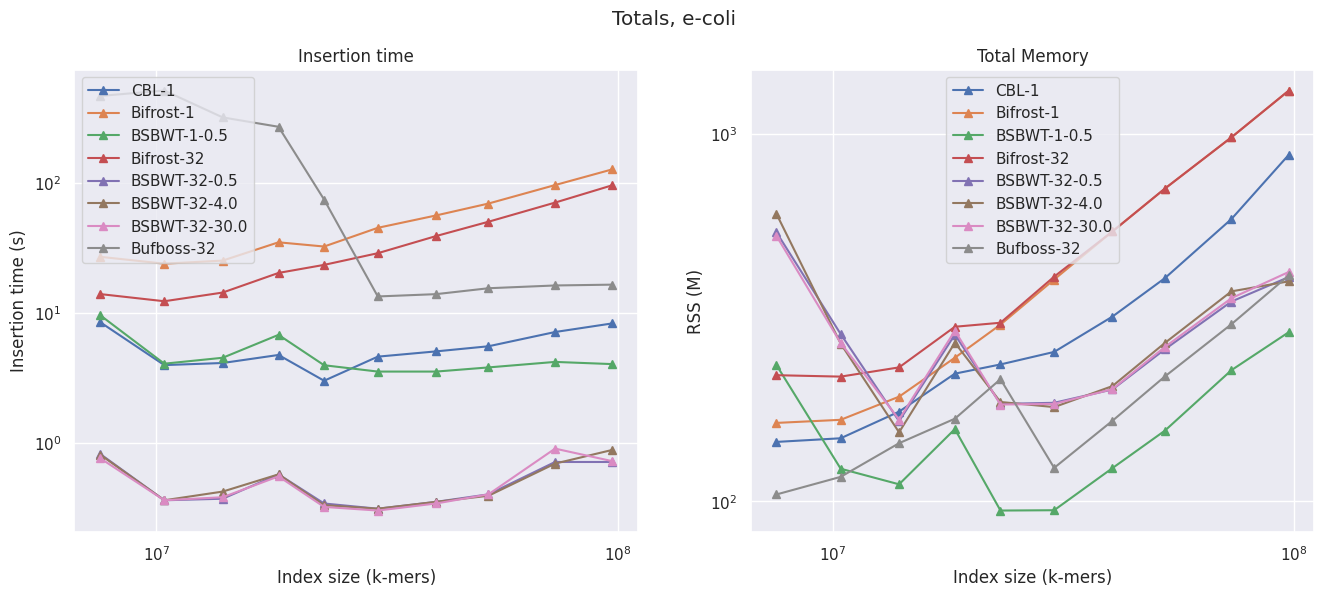

In [37]:
plot_time_and_space(coli_ins, "Totals, e-coli")

In [39]:
bact_ins = read_res("../bbb_res/ins_bact.txt")

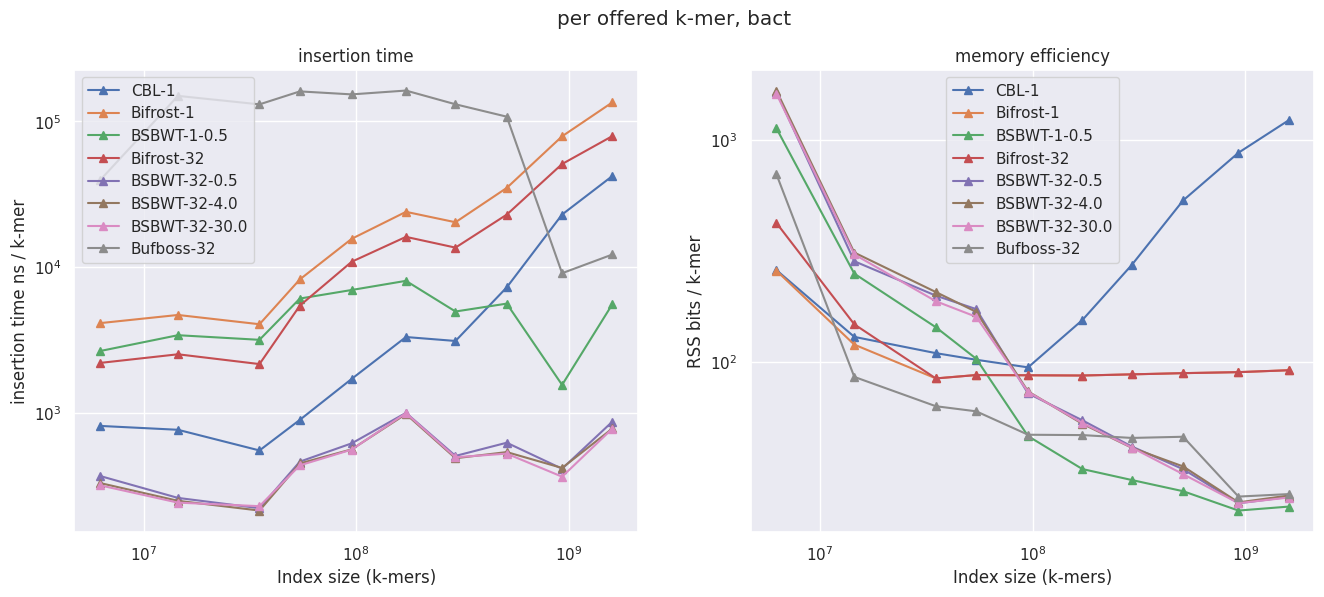

In [40]:
plot_time_and_space_per_kmer(bact_ins, bact_ins["offered"], "per offered k-mer, bact")

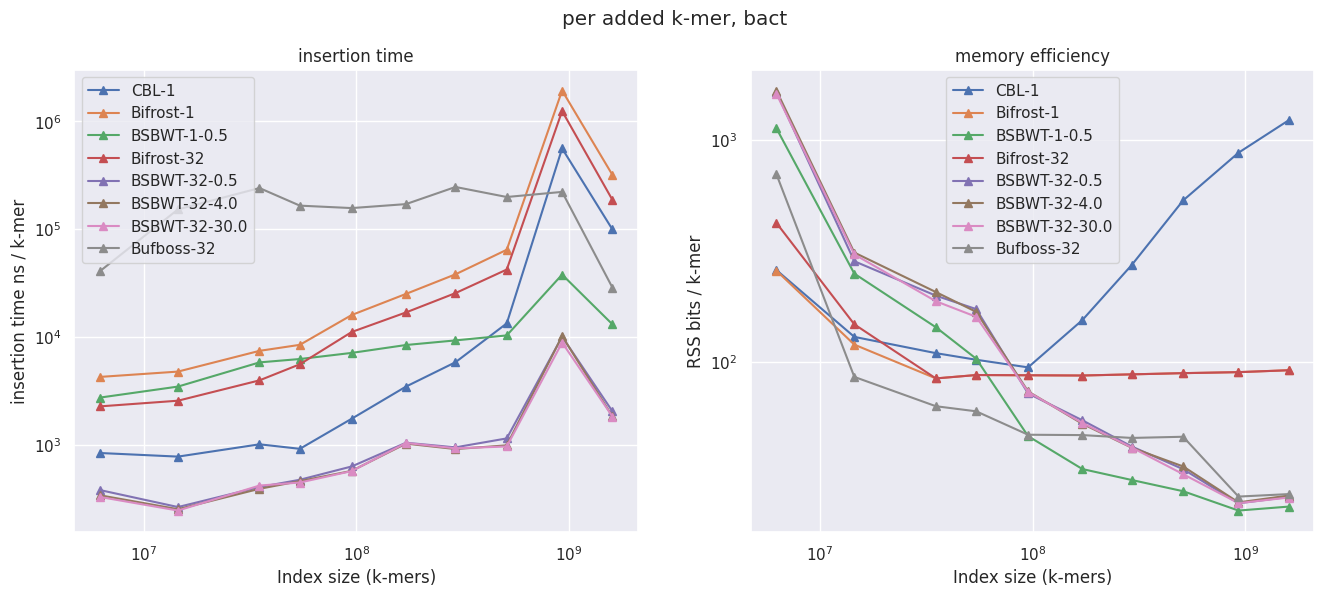

In [41]:
plot_time_and_space_per_kmer(bact_ins, bact_ins["added"], "per added k-mer, bact")

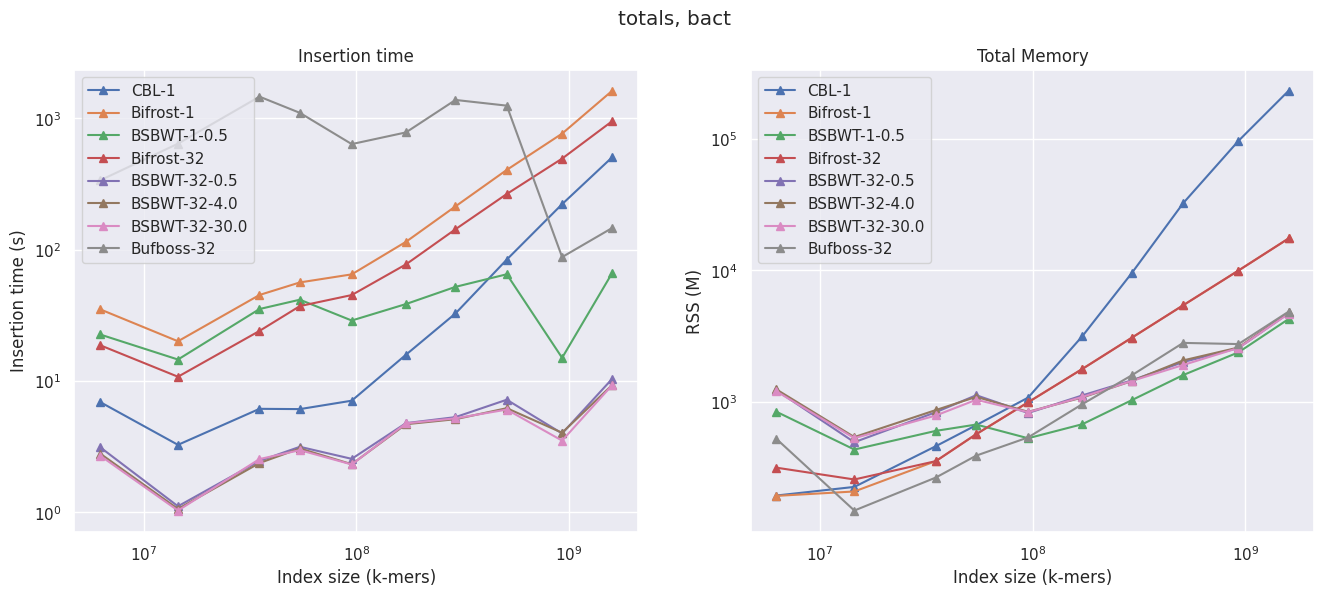

In [42]:
plot_time_and_space(bact_ins, "totals, bact")